In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


In [2]:
# pip install keras
import keras; print(keras.__version__)

2.3.1


In [3]:
# pip install tensorflow

In [4]:
# pip install graphviz

In [5]:
# pip install pydot

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [7]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [8]:
test.isnull().sum()

id             0
description    0
dtype: int64

In [9]:
train.head()
print(train.shape)

(4087, 3)


In [10]:
bins = [0,1,2,3]
review_names = ['excellent', 'good', 'bad']
train['ratingCategorical'] = pd.cut(train['ratingCategory'], bins, labels=review_names, include_lowest=True, right=False)

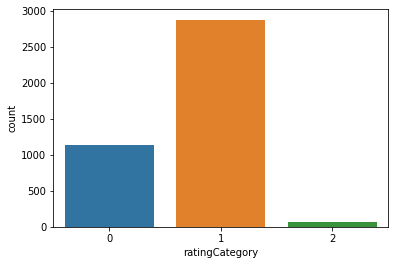

In [11]:
import seaborn as sns

sns.countplot(x='ratingCategory', data=train)

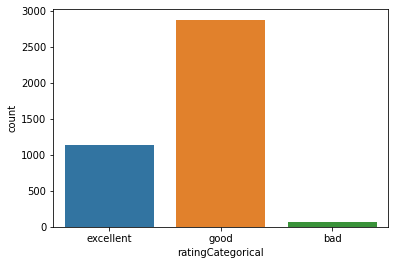

In [12]:
sns.countplot(x='ratingCategorical', data=train)

In [13]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [14]:
X = []
sentences = list(train["description"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = train['ratingCategorical']

In [15]:
train['description'] = train['description'].apply(preprocess_text)

In [16]:
test['description'] = test['description'].apply(preprocess_text)

In [17]:
# X_train = train['description']
# X_test = test['description']

# y_train = train['ratingCategorical']

In [18]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [20]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [21]:
y_test = to_categorical(y_test)


In [22]:
# X = []
# sentences = list(train["description"])
# for sen in sentences:
#     X.append(preprocess_text(sen))

# y = train['ratingCategory']

In [23]:
# they had this whole dataset together 
# then they broke it down to train test split

In [24]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros
import os

GLOVE_DIR = 'data'
embeddings_dictionary = dict()
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

# Glove file
# glove_file = 'data/glove.6B.100d.txt'

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary [word] = vector_dimensions

# glove_file.close()

Found 400000 word vectors.


In [27]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
# My working solution for now
# GLOVE_DIR = 'data'
# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

In [29]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
LSTM_Layer_2 = LSTM(128)(LSTM_Layer_1)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_2)# changed the Dense(3 to Dense(1 

model = Model(inputs=deep_inputs, outputs=dense_layer_1)

#original setting for the model from the article 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])



ValueError: Input 0 is incompatible with layer lstm_2: expected ndim=3, found ndim=2

In [ ]:
print(model.summary())


In [ ]:
# Error on line below with GraphViz maybe not set in PATH

In [ ]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
submission = model.predict(X_test)

In [ ]:
type(submission)


In [ ]:
print(submission)


In [ ]:
print(len(submission))

In [ ]:
out_df = pd.DataFrame(submission,columns=['0', '1', '2'])


In [ ]:
out_df.tail(150)

In [ ]:
out_df.describe()

In [ ]:
# ------------------ ! --------------------------

In [ ]:
# Predictions on test sample
# pred = gs_lr_tfidf.predict(test['description'])

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
submission['ratingCategory'].value_counts()

In [ ]:
subNumber = 700

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./data/submission{subNumber}.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()